In [1]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm

from sklearn.preprocessing import PolynomialFeatures
from utils.numerical_differentiation.tikhonov import TikhonovDifferentiation

from scipy.linalg import lstsq
from scipy.integrate import odeint
from scipy.sparse import tril, eye, coo_matrix
from scipy import interpolate
from scipy import signal

import pandas as pd

import matplotlib.pyplot as plt
from derivative import dxdt

# Install R packages to run on Python
# import rpy2's package module
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr

In [2]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def vanderpol(x, t, gamma=1, kappa=1, epsilon=2):
    return [
            x[1],
            -kappa * x[0] - gamma * x[1] - epsilon * x[1] * x[0] ** 2
            ]

gamma=1
kappa=1
epsilon=2

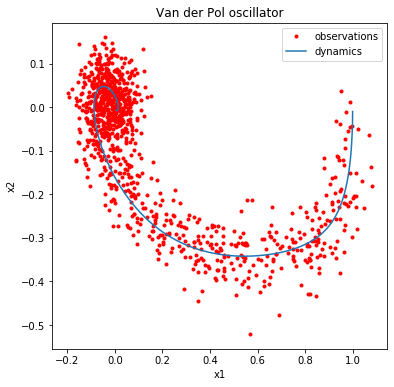

In [3]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [1, 0]
X = odeint(vanderpol, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -kappa * x1 - gamma * x2 - epsilon * x2 * x1 ** 2

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.05
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Van der Pol oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

## Cubic smoothing splines

$\hat{\beta} = \text{argmin} \frac{1}{2} ||y - \beta||_2^2 + \lambda ||D^{(k+1)}\beta||_1$

In [4]:
# CUBIC SMOOTHING SPLINE

y_sspline = []
dy_sspline = []
error_sspline = []
residual_sspline = []
reg_residual_sspline = []
gcv_sspline = []

#Define the array of lambdas
n_lambdas = 1000
lambdas_sspline = np.logspace(-12,1,n_lambdas)

#Loop over all state variables
for state in range(n_states):

    # Transform into R vectors
    r_y = robjects.FloatVector(Y[:,state])
    r_t = robjects.FloatVector(t)
    
    y_ss = np.zeros((m_samples,n_lambdas))
    dy_ss = np.zeros((m_samples,n_lambdas))
    error_dy_ss = np.zeros(n_lambdas)
    reg_residual = np.zeros(n_lambdas)
    residual = np.zeros(n_lambdas)
    gcv = np.zeros(n_lambdas)
    
    #Create trendfilter object with specific inputs
    r_smooth_spline = robjects.r['smooth.spline'] #extract R function
    
    for i, reg_lambda in enumerate(lambdas_sspline): 
        
        #Evaluate fitted data to specific grid r1_t ( Need to convert into np.array )
        kwargs = {"x": r_t, "y": r_y, "lambda": float(reg_lambda)}
        spline1 = r_smooth_spline(**kwargs)
#         y_ss[:,i] = np.array(robjects.r['predict'](spline1,robjects.FloatVector(r_t)).rx2('y'))
        y_ss[:,i] = np.array(spline1.rx2('y'))
        df_ss = np.array(spline1.rx2('df'))

        y_ss_ss = interpolate.splrep(r_t, y_ss[:,i], k=3, s=0)
        dy_ss[:,i] = interpolate.splev(r_t, y_ss_ss, der=1)
        ddy_ss = interpolate.splev(r_t, y_ss_ss, der=2)
        
        #Errors and residuals for each lambda
        reg_residual[i] = np.sum(ddy_ss ** 2)
        residual[i] = np.sum((r_y - y_ss[:,i]) ** 2)
        error_dy_ss[i] = norm(dy_ss[:,i] - dX[:,state])/norm(dX[:,state])
        gcv[i] = 1/m_samples * np.sum(((r_y - y_ss[:,i])/(1 - df_ss/m_samples)) ** 2)
        
    y_sspline.append(y_ss)#Append an array to a list for each state
    dy_sspline.append(dy_ss)
    error_sspline.append(error_dy_ss)
    residual_sspline.append(residual)
    reg_residual_sspline.append(reg_residual)
    gcv_sspline.append(gcv)

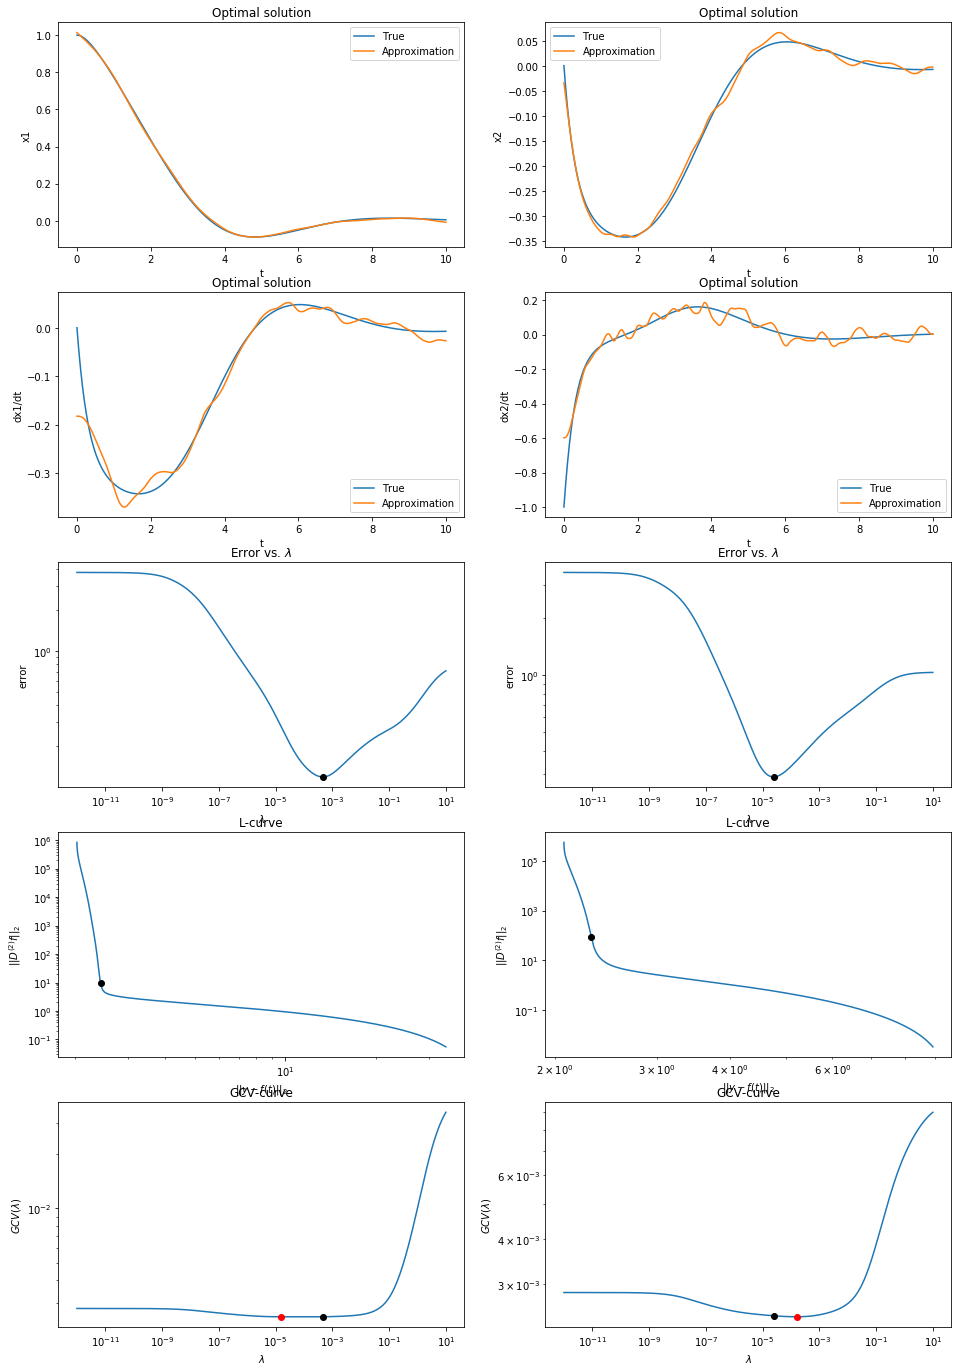

In [5]:
# Compute the lambda that yields the minimum error

fig,axs = plt.subplots(5,n_states,figsize = (16,24))

for state in range(n_states):
    
    lambda_min_indx = np.argmin(error_sspline[state])
    lambda_min_gcv_indx = np.argmin(gcv_sspline[state])
    
    axs[0,state].plot(t,X[:,state])
    axs[0,state].plot(t,y_sspline[state][:,lambda_min_indx])
    axs[0,state].set_title('Optimal solution')
    axs[0,state].set_xlabel('t')
    axs[0,state].set_ylabel(f'x{state+1}')
    axs[0,state].legend(['True','Approximation'])
    
    axs[1,state].plot(t,dX[:,state])
    axs[1,state].plot(t,dy_sspline[state][:,lambda_min_indx])
    axs[1,state].set_title('Optimal solution')
    axs[1,state].set_xlabel('t')
    axs[1,state].set_ylabel(f'dx{state+1}/dt')
    axs[1,state].legend(['True','Approximation'])
    
    axs[2,state].loglog(lambdas_sspline,error_sspline[state])
    axs[2,state].loglog(lambdas_sspline[lambda_min_indx],error_sspline[state][lambda_min_indx],'ko')
    axs[2,state].set_title('Error vs. $\lambda$')
    axs[2,state].set_xlabel('$\lambda$')
    axs[2,state].set_ylabel('error')
    
    axs[3,state].loglog(residual_sspline[state],reg_residual_sspline[state])
    axs[3,state].loglog(residual_sspline[state][lambda_min_indx],reg_residual_sspline[state][lambda_min_indx],'ko')
    axs[3,state].set_title('L-curve')
    axs[3,state].set_xlabel(r'$||y - f(t)||_2$')
    axs[3,state].set_ylabel(r'$||D^{(2)}f||_2$')   
    
    axs[4,state].loglog(lambdas_sspline,gcv_sspline[state])
    axs[4,state].loglog(lambdas_sspline[lambda_min_indx],gcv_sspline[state][lambda_min_indx],'ko')
    axs[4,state].loglog(lambdas_sspline[lambda_min_gcv_indx],gcv_sspline[state][lambda_min_gcv_indx],'ro')
    axs[4,state].set_title('GCV-curve')
    axs[4,state].set_xlabel(r'$\lambda$')
    axs[4,state].set_ylabel(r'$GCV(\lambda)$')

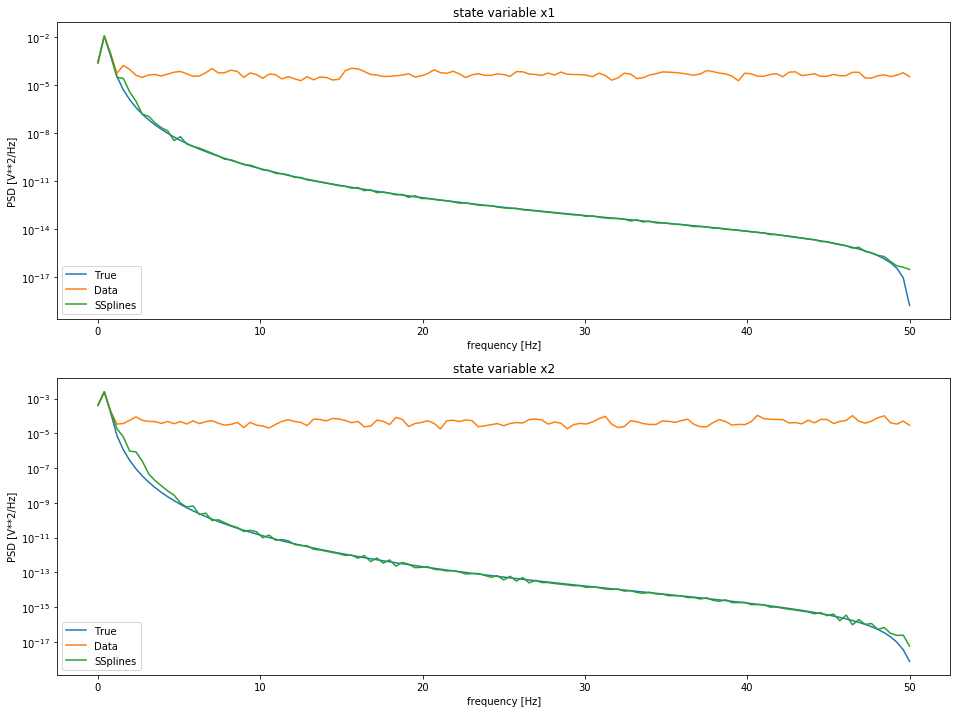

In [6]:
# POWER SPECTRAL DENSITY ANALYSIS
fig2,axs2 = plt.subplots(n_states,1,figsize = (16,12))

for state in range(n_states):
    
    f_true, Pxx_true = signal.welch(X[:,state], fs = 1/dt)
    f_data, Pxx_data = signal.welch(Y[:,state], fs = 1/dt)
    f_ss, Pxx_ss = signal.welch(y_sspline[state][:,lambda_min_indx], fs = 1/dt)

    axs2[state].semilogy(f_true, Pxx_true)
    axs2[state].semilogy(f_data, Pxx_data)
    axs2[state].semilogy(f_ss, Pxx_ss)
    axs2[state].set_title(f'state variable x{state+1}')
    axs2[state].set_xlabel('frequency [Hz]')
    axs2[state].set_ylabel('PSD [V**2/Hz]')
    axs2[state].legend(['True','Data','SSplines'])

In [7]:
#ERROR ANALYSIS

error_x = np.zeros(n_states)
error_dx = np.zeros(n_states)

for state in range(n_states):

    #Error in the states
    error_x[state] = ((y_sspline[state][:,lambda_min_indx] - X[:,state]) ** 2).mean()

    #Error in the state time-derivatives
    error_dx[state] = ((dy_sspline[state][:,lambda_min_indx] - dX[:,state]) ** 2).mean()
    
errors = pd.DataFrame([error_x, error_dx], index = ['state 1','state 2'], columns=['x error','dx error'])
errors

,x error,dx error
state 1,0.000061,0.000070
state 2,0.001645,0.001849
